## Finding the Optimal Epsilon for Adversarial Images with Regularization Coefficients of L1 and L2 = 0.0001

Importing the necessary modules like theano, tensor, sandbox, numpy, pickle, matplotlib

In [10]:
#importing theano, tensor, sandbox, numpy, pickle, matplotlib
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import pickle as cPickle
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use('Agg')
#from pprint import pprint

Defining the required functions to make use of weights, RMS prop, Neural Network model, one hot and MNIST train, test and digits

In [34]:
################## Taken from https://github.com/robertlacok/mnist-adversarial-examples #########################
################### Taken from https://github.com/Newmu/Theano-Tutorials/ #######################################

#Definitions
# Convert into correct type for theano
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

# Weights are shared theano variables
def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

# RMSProp to update weights
def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

# Dropout regularization 
def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

# Neural network model, 3 fully connected layers
def model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
	# Input layer: dropout + relu 
    X = dropout(X, p_drop_input)
    h = T.nnet.relu(T.dot(X, w_h))
	
	# Hidden layer: dropout + relu 
    h = dropout(h, p_drop_hidden)
    h2 = T.nnet.relu(T.dot(h, w_h2))
	
	# Output layer: dropout + softmax 
    h2 = dropout(h2, p_drop_hidden)
    py_x = T.nnet.softmax(T.dot(h2, w_o))
    return h, h2, py_x

#OneHot
def one_hot(x,n):
	if type(x) == list:
		x = np.array(x)
	x = x.flatten()
	o_h = np.zeros((len(x),n))
	o_h[np.arange(len(x)),x] = 1
	return o_h

#MNIST Data Train Test
def mnist(ntrain=60000,ntest=10000,onehot=True):
	data_dir = os.path.join(datasets_dir,'mnist/')
	fd = open(os.path.join(data_dir,'train-images-idx3-ubyte'))
	loaded = np.fromfile(file=fd,dtype=np.uint8)
	trX = loaded[16:].reshape((60000,28*28)).astype(float)

	fd = open(os.path.join(data_dir,'train-labels-idx1-ubyte'))
	loaded = np.fromfile(file=fd,dtype=np.uint8)
	trY = loaded[8:].reshape((60000))

	fd = open(os.path.join(data_dir,'t10k-images-idx3-ubyte'))
	loaded = np.fromfile(file=fd,dtype=np.uint8)
	teX = loaded[16:].reshape((10000,28*28)).astype(float)

	fd = open(os.path.join(data_dir,'t10k-labels-idx1-ubyte'))
	loaded = np.fromfile(file=fd,dtype=np.uint8)
	teY = loaded[8:].reshape((10000))

	trX = trX/255.
	teX = teX/255.

	trX = trX[:ntrain]
	trY = trY[:ntrain]

	teX = teX[:ntest]
	teY = teY[:ntest]

	if onehot:
		trY = one_hot(trY, 10)
		teY = one_hot(teY, 10)
	else:
		trY = np.asarray(trY)
		teY = np.asarray(teY)

	return trX,teX,trY,teY

#MNIST 
def plot_mnist_digit(image1, image2, name1, name2):
    global count_attack
    image1 = np.reshape(image1,[1,784])
    image2 = np.reshape(image2,[1,784])
    #print 'test image confidence' , np.mean(predict_conf(image1)), 'adversarial image confidence', np.mean(predict_conf(image2))
    if (predict(image1) != predict(image2)):
        count_attack = count_attack + 1

* Here, we are loading the MNIST data into the media/datasets folder
* Initialized weights using init_weights
* Loaded the model as LearnedParams using pickle
* We found Confidence of test and defined Cost using updated theano expressions

In [35]:
######## Training sizes and parameters taken from https://github.com/robertlacok/mnist-adversarial-examples #######

#Loading MNIST data
datasets_dir = 'media/datasets/'
srng = RandomStreams()
TRAINING = True

print('MNIST data Loaded')
Xtr, Xts, ytr, yts = mnist(onehot=True)

# Initialize theano variables for X, Y, and shared variables for weights
X = T.fmatrix()
Y = T.fmatrix()

if TRAINING:
    # For training of the net, we initialize weights to random values
    w_h = init_weights((784, 625))
    w_h2 = init_weights((625, 625))
    w_o = init_weights((625, 10))
    params = [w_h, w_h2, w_o]
else:
    # To run experiments, just read weights we learned before
    print('Loading model...')
    with open('LearnedParamsL1.model','rb') as fp:
        params = cPickle.load(fp)
    w_h, w_h2, w_o = params

# Dropout model for training
noise_h, noise_h2, noise_py_x = model(X, w_h, w_h2, w_o, 0.2, 0.5)
# Use all-weights model for prediction
h, h2, py_x = model(X, w_h, w_h2, w_o, 0., 0.)
y_x = T.argmax(py_x, axis=1)

# To find confidence of test set use the following value of y_x
y_x1 = T.max(py_x, axis = 1)
# Define cost and update theano expressions

l1 = abs(w_h).sum() + abs(w_h2).sum() + abs(w_o).sum()
l2 = (w_h**2).sum() + (w_h2**2).sum() + (w_o**2).sum()

MNIST data Loaded


* Chose l1 and l2 coefficents as 0.0001
* Defined Cost and Train and predicted using theano function
* Trained MNIST data and leaned weights are then dumped using pickel

In [36]:
################################################# Our Part of the code #######################################################

#l1 and l2 coefficients & Training Data
#=================== Parameters to chnge ===============================#
l1coef = 0.0001
l2coef = 0.0001
#=======================================================================#

cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y)) + l1coef * l1 + l2coef * l2
updates = RMSprop(cost, params, lr=0.001)

# Define train and predict theano functions
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)

predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)
predict_conf = theano.function(inputs=[X], outputs=y_x1, allow_input_downcast=True)

if TRAINING:
    print('Training MNIST data...')
    # Train in 50 epochs
    for i in range(50):
        # Select minibatch and train
        for start, end in zip(range(0, len(Xtr), 128), range(128, len(Xtr), 128)):
            cost = train(Xtr[start:end], ytr[start:end])
        print(i, ':  ', np.mean(np.argmax(yts, axis=1) == predict(Xts)))
        # In each step save the learned weights
        with open('LearnedParamsL1.model','wb') as fp:
            cPickle.dump(params,fp)

Training MNIST data...
0 :   0.9179
1 :   0.9407
2 :   0.948
3 :   0.9574
4 :   0.9586
5 :   0.9622
6 :   0.9607
7 :   0.9665
8 :   0.9669
9 :   0.9641
10 :   0.9672
11 :   0.9674
12 :   0.9692
13 :   0.9643
14 :   0.9667
15 :   0.9638
16 :   0.967
17 :   0.9691
18 :   0.9647
19 :   0.9708
20 :   0.9644
21 :   0.9711
22 :   0.9686
23 :   0.9689
24 :   0.9663
25 :   0.9686
26 :   0.9688
27 :   0.9684
28 :   0.9702
29 :   0.969
30 :   0.9699
31 :   0.9699
32 :   0.9662
33 :   0.9699
34 :   0.9687
35 :   0.9675
36 :   0.9679
37 :   0.97
38 :   0.9679
39 :   0.9707
40 :   0.9722
41 :   0.97
42 :   0.9677
43 :   0.9679
44 :   0.9694
45 :   0.9693
46 :   0.9693
47 :   0.9707
48 :   0.9684
49 :   0.9693


* EPS values are taken in a range of 0 to 0.5
* Created Adversarial images taking each Epsilon value at a time
* For each Epsilon, Average error rate and Average Confidence are calculated

In [37]:
################################################# Our Part of the code #######################################################

#=========================== ADVERSARIAL COMPONENT OF THE CODE ============================#
# Creating Adversarial Examples
cost_ad = T.mean(T.nnet.categorical_crossentropy(py_x, Y))
get_grad = theano.function(inputs=[X, Y], outputs=T.grad(cost_ad, X), allow_input_downcast=True)

eps_values = np.linspace(0,0.5,11)
err = []
conf = []
for EPS in eps_values:
    eps = EPS
    adX = []
    for i in range(len(Xts)):
        gs = get_grad(Xts[i:i+1], yts[i:i+1]).T[:,0]
        img_ad = Xts[i] + eps * np.sign(gs) 
        adX.append(img_ad)
    erri = 1-(np.mean(np.argmax(yts, axis=1) == predict(adX)))
    err.append(erri)
    confi = np.mean(predict_conf(adX))
    conf.append(confi)
    print('Creating Adversarial set, e=', EPS)

Creating Adversarial set, e= 0.0
Creating Adversarial set, e= 0.05
Creating Adversarial set, e= 0.1
Creating Adversarial set, e= 0.15
Creating Adversarial set, e= 0.2
Creating Adversarial set, e= 0.25
Creating Adversarial set, e= 0.3
Creating Adversarial set, e= 0.35
Creating Adversarial set, e= 0.4
Creating Adversarial set, e= 0.45
Creating Adversarial set, e= 0.5


Variation of Average Error Rate with Epsilon

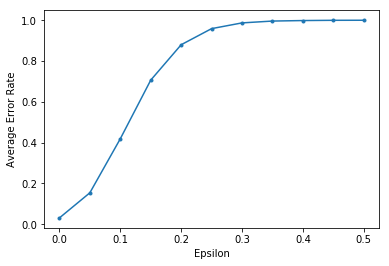

In [40]:
################################################# Our Part of the code #######################################################

#Error Vs Epsilon
plt.plot(eps_values, err, marker='.')
plt.xlabel('Epsilon')
plt.ylabel('Average Error Rate')

To find the minimum Epsilon, Variation of Average Confidence is plotted

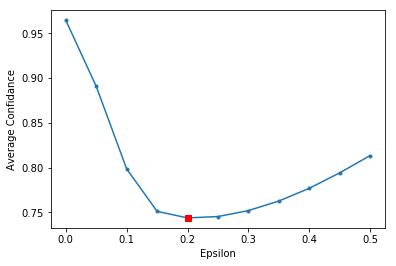

In [41]:
################################################# Our Part of the code #######################################################

#Confidance Vs Epsilon
confmin = np.argmin(conf)
imin = np.argmin(conf)
conf_min = conf[imin]
eps_min = eps_values[imin]

plt.plot(eps_values, conf, marker='.')
plt.xlabel('Epsilon')
plt.ylabel('Average Confidance')
plt.plot(eps_min, conf_min, 'rs--')